In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
# print(os.getcwd())
# sys.path.append(os.getcwd())

import logging
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import torch.nn as nn
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.0.0+cu118
Torchvision version: 0.15.1+cu118
CUDA is available: True


In [2]:
datadir= Path('/dlab/ldrive/CBT/USLJ-DSDE_DATA-I10008/BenchmarkDatasets/hpa-single-cell-image-classification')
train_dataset_dir = datadir.joinpath('train')
train_csv = datadir.joinpath('train_select_1K.csv')

In [5]:
from func.HPASCDataset import HPASCDataset, TrDataset
from func.trainer import load_train_objs
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2, Compose, Resize, ToTensor

input_ch_ct = 3
debug_size = 10
n_class = 19
mean = [0.0540, 0.0530, 0.0804, 0.0806]
std = [0.1420, 0.0831, 0.1272, 0.1229]
if isinstance(input_ch_ct, int): 
    mean = mean[:input_ch_ct]
    std = std[:input_ch_ct]
elif isinstance(input_ch_ct, list): 
    mean = [mean[ch] for ch in input_ch_ct]
    std = [std[ch] for ch in input_ch_ct]
print(mean)
print(std)

tf_dataset = Compose(
        [
            ToTensor(), 
            v2.Resize(size = (1024, 1024), antialias = True),
        ]
    )

HPA_dataset = HPASCDataset(
                        input_csv = train_csv, 
                        root = train_dataset_dir, 
                        input_ch_ct = input_ch_ct,
                        n_class = n_class, 
                        debug_size = debug_size,
                        transform = tf_dataset
                        )

dataloader = DataLoader(
                    HPA_dataset,
                    batch_size=64,
                    pin_memory=True,
                    num_workers=32,
                    shuffle=False)

[0.054, 0.053, 0.0804]
[0.142, 0.0831, 0.1272]


In [6]:
tv_v1_train = Compose(
        [   
            v2.RandomResizedCrop(size=(1024, 1024), antialias=True),
            v2.RandomHorizontalFlip(p = 0.5),
            v2.RandomVerticalFlip(p = 0.5),
            v2.RandomRotation(degrees=(0, 180)),
            v2.Normalize(mean = mean, std = std),
        ]
    )
    
tv_v1_val = Compose(
        [   
            v2.Resize(size = (1024, 1024), antialias = True),
            v2.Normalize(mean = mean, std = std),
        ]
    )

# data loader directly output tensor using default collate.
data = next(iter(dataloader))
image = data['image']
label = data['label']
print(image.shape)
print(image.max())
print(image.min())

out2 = tv_v1_train(image)
print(out2.shape)


torch.Size([10, 3, 1024, 1024])
tensor(1.0000)
tensor(0.)
torch.Size([10, 3, 1024, 1024])


In [13]:
def show_transformed_images(dataset, post_transform = None): 
    dataloader = DataLoader(
                    dataset,
                    batch_size=9,
                    pin_memory=True,
                    shuffle=True)
    batch = next(iter(dataloader))
    images = batch['image']
    labels = batch['label']

    if not post_transform is None:
        images = post_transform(images)
    
    labels_anno = []
    for label in labels: 
        labels_anno.append((label==1).nonzero().flatten().tolist())
    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize = (11, 11))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    print('labels', labels_anno)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels [[0], [16], [16], [0, 3], [0, 16], [8], [7], [0], [14]]


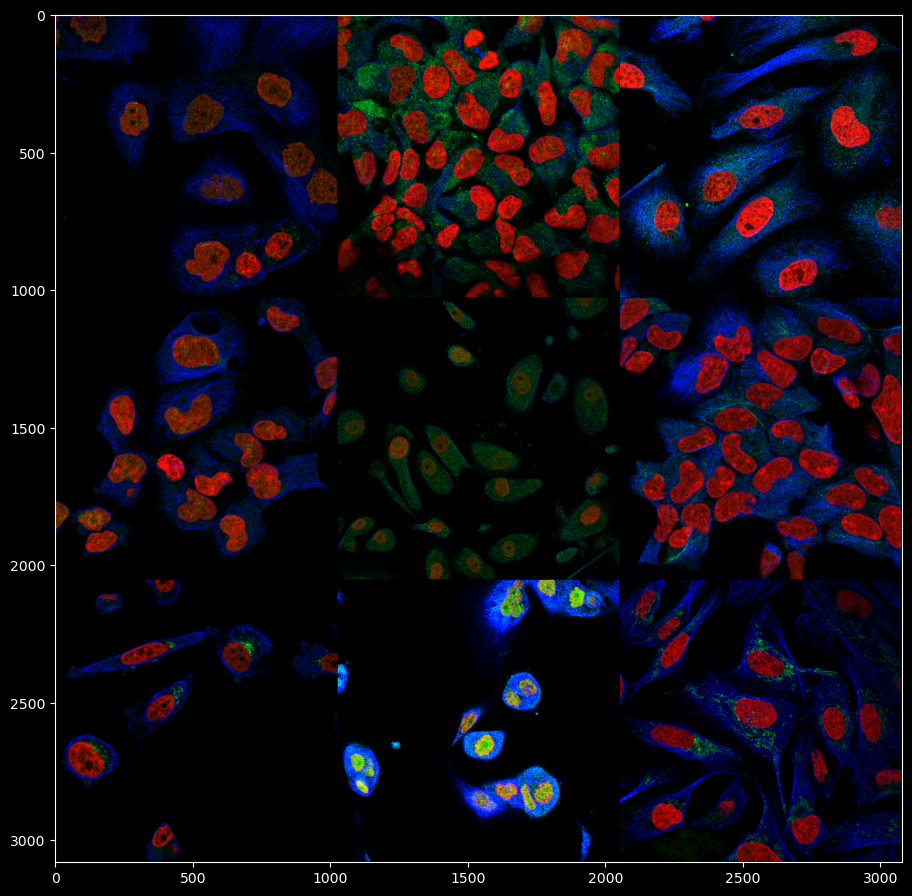

In [14]:
show_transformed_images(HPA_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels [[0], [0], [0, 3], [8], [14], [16], [0], [0, 16], [16]]


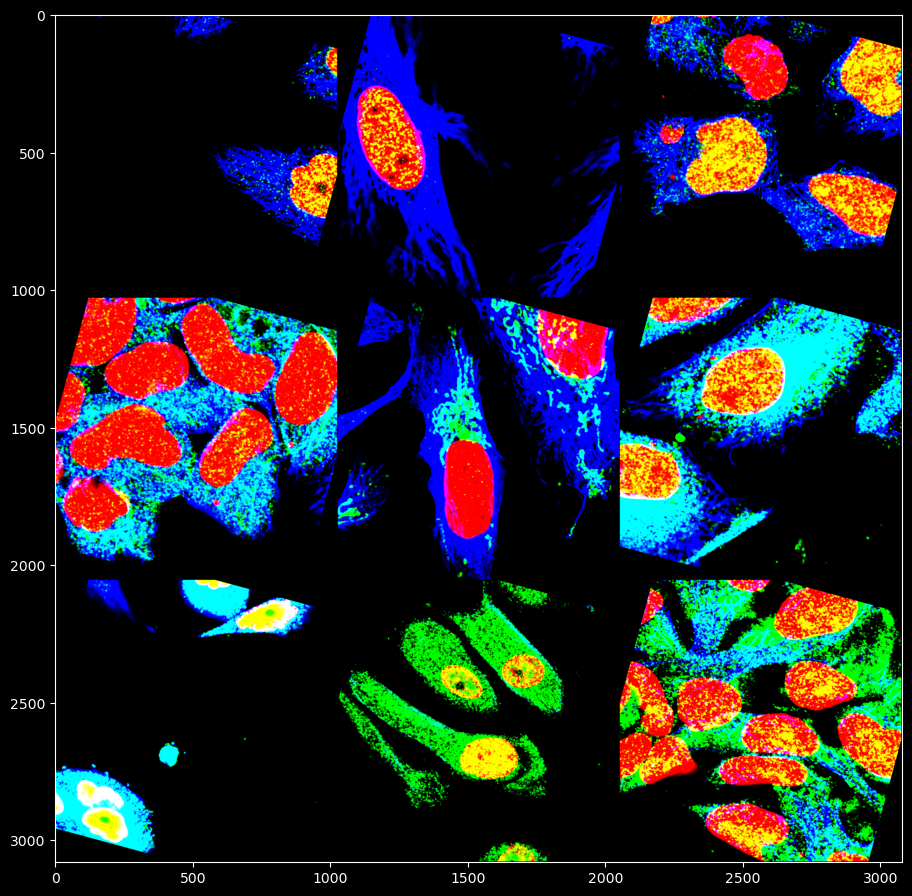

In [16]:
show_transformed_images(HPA_dataset, post_transform = tv_v1_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels [[14], [0], [0, 3], [0, 16], [7], [16], [0], [16], [8]]


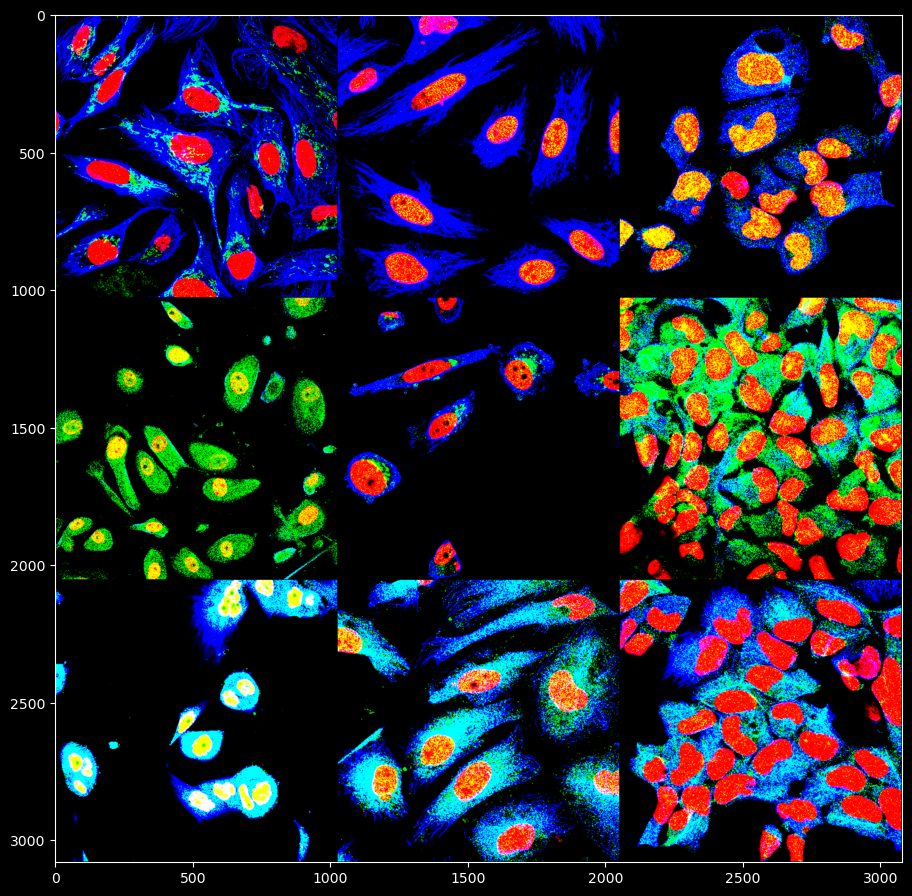

In [17]:
show_transformed_images(HPA_dataset, post_transform = tv_v1_val)